# Sentiment Analysis on Yelp Reviews  
## NLP Pre-processing Design and Framework

This notebook demonstrates the complete NLP preprocessing pipeline for sentiment analysis, including:
- Loading data from CSV (Kaggle dataset)
- Text cleaning
- Tokenization
- Stopword removal

This dataset focuses on customer opinions and feedback collected from Yelp, a popular online platform for reviewing businesses such as restaurants, cafes, and service providers.

hundreds of thousands of customer reviews, providing a large and diverse collection of real-world textual data.

Project Objevtive =
 to develop a sentiment analysis framework that can automatically classify customer reviews as positive or negative.

In [9]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import kagglehub


import joblib

nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Dataset Loading (CSV Input)

The Yelp Reviews Sentiment Dataset is loaded in CSV format.
This CSV file represents the raw input data before any preprocessing.


In [10]:
# Download dataset from Kaggle
path = kagglehub.dataset_download(
    "thedevastator/yelp-reviews-sentiment-dataset"
)

print("Dataset path:", path)

# Identify CSV file
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
print("CSV file found:", csv_file)

# Load raw dataset
raw_df = pd.read_csv(os.path.join(path, csv_file))

# Save raw CSV into Colab workspace
raw_df.to_csv("yelp_reviews_raw.csv", index=False)

print("Raw CSV saved to /content/")


Dataset path: C:\Users\ariaf\.cache\kagglehub\datasets\thedevastator\yelp-reviews-sentiment-dataset\versions\2
CSV file found: test.csv
Raw CSV saved to /content/


## 1. Dataset Source

The Yelp Reviews Sentiment Dataset is downloaded from Kaggle using the KaggleHub API.
The dataset is provided in CSV format.


In [11]:
# Download dataset from Kaggle
path = kagglehub.dataset_download(
    "thedevastator/yelp-reviews-sentiment-dataset"
)

print("Dataset path:", path)

# Identify CSV file
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
print("CSV file found:", csv_file)

# Load raw dataset
raw_df = pd.read_csv(os.path.join(path, csv_file))

# Save raw CSV into Colab workspace
raw_df.to_csv("yelp_reviews_raw.csv", index=False)

print("Raw CSV saved to /content/")


Dataset path: C:\Users\ariaf\.cache\kagglehub\datasets\thedevastator\yelp-reviews-sentiment-dataset\versions\2
CSV file found: test.csv
Raw CSV saved to /content/


In [12]:
raw_df = pd.read_csv("yelp_reviews_raw.csv")

print("Raw dataset shape:", raw_df.shape)
raw_df.head()


Raw dataset shape: (38000, 2)


,text,label
0,"Contrary to other reviews, I have zero complai...",1
1,Last summer I had an appointment to get new ti...,0
2,"Friendly staff, same starbucks fair you get an...",1
3,The food is good. Unfortunately the service is...,0
4,Even when we didn't have a car Filene's Baseme...,1


A working copy of the dataset is created to preserve the raw data.
All preprocessing steps are applied to this copy.


In [13]:
df = raw_df.copy()


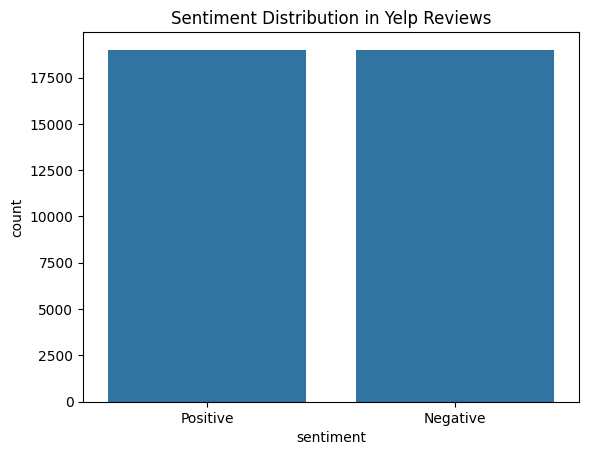

In [14]:
df["sentiment"] = df["label"].map({
    0: "Negative",
    1: "Positive"
})

sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution in Yelp Reviews")
plt.show()


## 2. NLP Pre-processing Design

Steps:
1. Text cleaning
2. Tokenization
3. Stopword removal

In [15]:
##TEXT CLEANING Cleaning the Noise using "re"

#Lowercase Conversion,Removing URLs,
#Removing Mentions/Hashtags,Removing Punctuation & Special Characters

#Conversion of all text to lowercase to ensure consistency
#Removal of URLs to eliminate irrelevant web links
##Removal of punctuation marks and numerical characters
#Removal of extra whitespace


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

df[["text", "clean_text"]].head()


,text,clean_text
0,"Contrary to other reviews, I have zero complai...",contrary to other reviews i have zero complain...
1,Last summer I had an appointment to get new ti...,last summer i had an appointment to get new ti...
2,"Friendly staff, same starbucks fair you get an...",friendly staff same starbucks fair you get any...
3,The food is good. Unfortunately the service is...,the food is good unfortunately the service is ...
4,Even when we didn't have a car Filene's Baseme...,even when we didnt have a car filenes basement...


In [16]:
##Tokenization & Stopword Removal

#It converts a long string of text into a list of individual words (Tokenization)
#Clean Text - process is the filter that removes distractions

stop_words = set(stopwords.words("english"))

def tokenize(text):
    return [w for w in text.split() if w not in stop_words]

df["tokens"] = df["clean_text"].apply(tokenize)

df[["clean_text", "tokens"]].head()


,clean_text,tokens
0,contrary to other reviews i have zero complain...,"[contrary, reviews, zero, complaints, service,..."
1,last summer i had an appointment to get new ti...,"[last, summer, appointment, get, new, tires, w..."
2,friendly staff same starbucks fair you get any...,"[friendly, staff, starbucks, fair, get, anywhe..."
3,the food is good unfortunately the service is ...,"[food, good, unfortunately, service, hit, miss..."
4,even when we didnt have a car filenes basement...,"[even, didnt, car, filenes, basement, worth, b..."


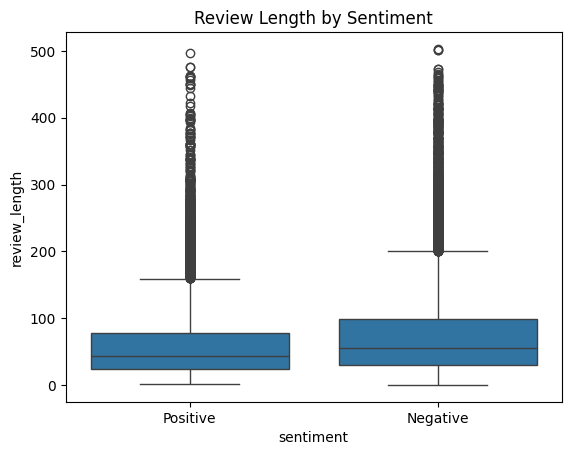

In [17]:
##Review Length Analysis (EDA Boost) Exploratory Data Analysis (EDA)

df["review_length"] = df["tokens"].apply(len)
#We are creating a new piece of information. We are counting how many words (tokens)
#are in each tweet after we cleaned them

sns.boxplot(x="sentiment", y="review_length", data=df)
plt.title("Review Length by Sentiment")
plt.show()

#I wanted to see if angry people write more than happy people.
#If negative reviews were always longer, the model could just use "length" to guess the sentiment

#Because the two groups look so similar, length doesn't tell us much.
#This proves that our model can't just count words; it has to actually "read"
#the specific words (like "great" vs. "bad") to understand the emotion

In [19]:
df.to_csv("yelp_reviews_cleaned.csv", index=False)
print("Cleaned CSV saved")


Cleaned CSV saved


In [20]:
#Load the dataset

df = pd.read_csv("yelp_reviews_cleaned.csv")

In [21]:
# Buang teks kosong
df = df.dropna(subset=["clean_text"])

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
# TF-IDF
tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=20000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [23]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

In [24]:
# SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

In [25]:
# Evaluation
def evaluate(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

results = []
results.append(evaluate("Logistic Regression", y_test, y_pred_lr))
results.append(evaluate("SVM", y_test, y_pred_svm))

results_df = pd.DataFrame(results)
results_df.to_csv("model_results.csv", index=False)

In [39]:
# Save models
joblib.dump(lr, "logistic_regression.pkl")
joblib.dump(svm, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print(results_df)

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.912763   0.910495  0.915526  0.913004
1                  SVM  0.910658   0.908401  0.913421  0.910904


# Task
Generate and display confusion matrices for Logistic Regression and SVM models, visualize their performance metrics (accuracy, precision, recall, F1-score) from `model_results.csv` using a bar chart, and perform a misclassification analysis by showing examples of wrongly predicted reviews by both models. Implement and demonstrate an interactive sentiment predictor function using `tfidf_vectorizer.pkl`, `logistic_regression.pkl`, and `svm_model.pkl` to predict sentiment for new text inputs. Finally, provide a summary comparing the model performances and discuss insights from the analysis.

## Plot Confusion Matrices

### Subtask:
Generate and display confusion matrices for both the Logistic Regression and SVM models. This will visualize the true positives, true negatives, false positives, and false negatives for each model, using the predicted and actual labels.


**Reasoning**:
The subtask requires generating and displaying confusion matrices for both Logistic Regression and SVM models. I will import the necessary function `confusion_matrix` and then calculate and plot the confusion matrices for each model using `seaborn.heatmap`.



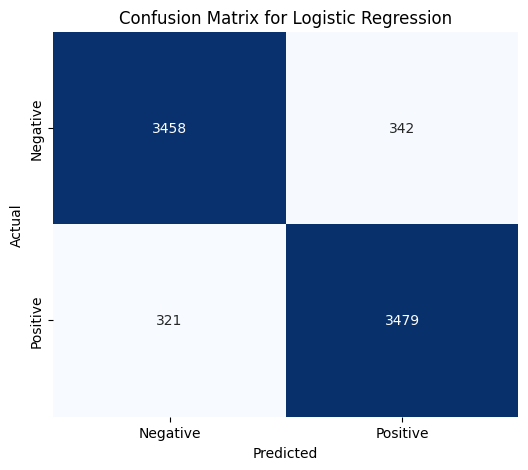

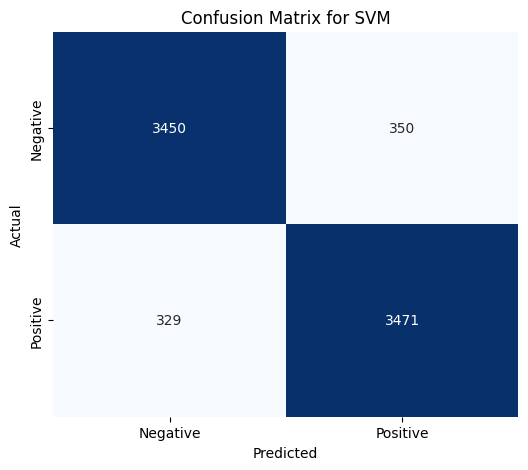

Generated and displayed confusion matrices for Logistic Regression and SVM.


In [27]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Generated and displayed confusion matrices for Logistic Regression and SVM.")

## Visualize Model Performance Metrics

### Subtask:
Create a comprehensive bar chart to visually compare the accuracy, precision, recall, and F1-score of the Logistic Regression and SVM models. This chart will be based on the 'results_df' DataFrame and should include a legend for clarity.


**Reasoning**:
The subtask requires reshaping the 'results_df' DataFrame from wide to long format and then creating a bar chart to compare the performance metrics of the models. I will use `pd.melt` to reshape the DataFrame and then `seaborn.barplot` to visualize the metrics.



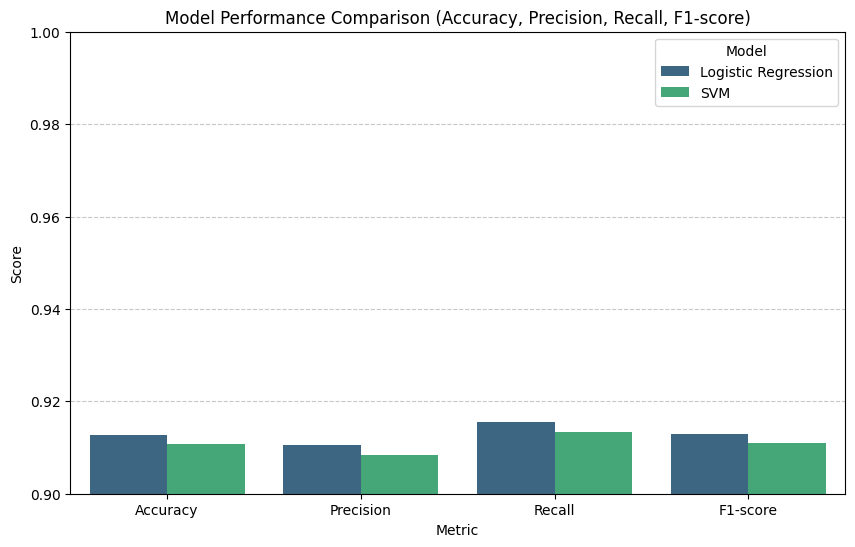

Generated and displayed a bar chart comparing model performance metrics.


In [29]:
metrics_df = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=metrics_df, palette="viridis")
plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1-score)")
plt.ylim(0.9, 1.0) # Set y-axis limits for better visualization of differences
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print("Generated and displayed a bar chart comparing model performance metrics.")

**Reasoning**:
The subtask now requires performing a misclassification analysis. This involves identifying reviews where the model's prediction differs from the actual sentiment. I will start by identifying the indices of misclassified reviews for both Logistic Regression and SVM by comparing their predictions (`y_pred_lr`, `y_pred_svm`) with the true labels (`y_test`).



In [30]:
misclassified_lr_indices = y_test[y_test != y_pred_lr].index
misclassified_svm_indices = y_test[y_test != y_pred_svm].index

print(f"Number of misclassified reviews by Logistic Regression: {len(misclassified_lr_indices)}")
print(f"Number of misclassified reviews by SVM: {len(misclassified_svm_indices)}")

Number of misclassified reviews by Logistic Regression: 663
Number of misclassified reviews by SVM: 679


**Reasoning**:
Now that the misclassified indices are identified, I will display a few examples of reviews that were misclassified by the Logistic Regression model, showing the original text, the true label, and the predicted label.



In [31]:
print("\n--- Examples of Misclassified Reviews by Logistic Regression ---")
misclassified_lr_df = df.loc[misclassified_lr_indices].copy()
misclassified_lr_df['predicted_label'] = y_pred_lr[y_test.index.get_indexer(misclassified_lr_indices)]
print("LR Misclassifications (first 5):")
print(misclassified_lr_df[['text', 'label', 'predicted_label']].head())


--- Examples of Misclassified Reviews by Logistic Regression ---
LR Misclassifications (first 5):
                                                    text  label  \
19332  Came in late on a Wednesday night about 30 min...      1   
28039    We really like the service and food at the bar.      1   
9722   This place is all about the hotel and the shop...      1   
12218  Stayed at a hotel downtown. Went to Diesel on ...      0   
32484  The price is great for salon service on the st...      0   

       predicted_label  
19332                0  
28039                0  
9722                 0  
12218                1  
32484                1  


**Reasoning**:
Following the misclassification analysis for Logistic Regression, the next logical step is to display a few examples of reviews that were misclassified by the SVM model, showing the original text, the true label, and the predicted label.



In [32]:
print("\n--- Examples of Misclassified Reviews by SVM ---")
misclassified_svm_df = df.loc[misclassified_svm_indices].copy()
misclassified_svm_df['predicted_label'] = y_pred_svm[y_test.index.get_indexer(misclassified_svm_indices)]
print("SVM Misclassifications (first 5):")
print(misclassified_svm_df[['text', 'label', 'predicted_label']].head())


--- Examples of Misclassified Reviews by SVM ---
SVM Misclassifications (first 5):
                                                    text  label  \
19332  Came in late on a Wednesday night about 30 min...      1   
9722   This place is all about the hotel and the shop...      1   
12218  Stayed at a hotel downtown. Went to Diesel on ...      0   
32484  The price is great for salon service on the st...      0   
2745   Great pizza...but as another reviewer mentione...      1   

       predicted_label  
19332                0  
9722                 0  
12218                1  
32484                1  
2745                 0  


**Reasoning**:
The next step is to implement an interactive sentiment predictor function. This requires loading the previously saved TF-IDF vectorizer, Logistic Regression model, and SVM model. I will use `joblib.load` for this purpose.



In [33]:
import joblib

# Load the saved models and TF-IDF vectorizer
lr_loaded = joblib.load('logistic_regression.pkl')
svm_loaded = joblib.load('svm_model.pkl')
tfidf_loaded = joblib.load('tfidf_vectorizer.pkl')

print("Models and TF-IDF vectorizer loaded successfully.")

Models and TF-IDF vectorizer loaded successfully.


**Reasoning**:
I need to define helper functions for text cleaning and tokenization, which are essential for preprocessing new input text before it can be fed into the loaded models for sentiment prediction. These functions (`clean_text` and `tokenize`) were defined earlier in the notebook, and need to be available for the interactive prediction function.



In [34]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text):
    return [w for w in text.split() if w not in stop_words]

print("Text cleaning and tokenization helper functions defined.")

Text cleaning and tokenization helper functions defined.


## Create New Test Dataset and Predict Sentiment

This section demonstrates how to use the `predict_sentiment` function with a new set of input texts. We'll create a small DataFrame with some sample reviews to simulate new data.

**Reasoning**:
Now that the models and preprocessing functions are loaded and defined, I will create an interactive function `predict_sentiment` that takes a new text input, preprocesses it using the `clean_text` and `tokenize` functions, transforms it using the loaded TF-IDF vectorizer, and then predicts the sentiment using both the loaded Logistic Regression and SVM models. This function will then print the predicted sentiment for each model.



In [35]:
def predict_sentiment(text):
    # Clean and tokenize the input text
    cleaned_text = clean_text(text)
    # Tokenization is implicit in TF-IDF for word-based features, but we defined it for general NLP flow
    # For TF-IDF, it expects a string, not a list of tokens, so we'll pass cleaned_text directly

    # Transform the text using the loaded TF-IDF vectorizer
    text_tfidf = tfidf_loaded.transform([cleaned_text])

    # Predict sentiment using Logistic Regression
    lr_prediction = lr_loaded.predict(text_tfidf)[0]
    lr_sentiment = "Positive" if lr_prediction == 1 else "Negative"

    # Predict sentiment using SVM
    svm_prediction = svm_loaded.predict(text_tfidf)[0]
    svm_sentiment = "Positive" if svm_prediction == 1 else "Negative"

    print(f"\nInput Text: {text}")
    print(f"Cleaned Text: {cleaned_text}")
    print(f"Logistic Regression Predicted Sentiment: {lr_sentiment}")
    print(f"SVM Predicted Sentiment: {svm_sentiment}")

    return lr_sentiment, svm_sentiment

# Demonstrate the interactive predictor with examples
print("--- Interactive Sentiment Predictor ---")
predict_sentiment("This product is amazing! I love it.")
predict_sentiment("I am so disappointed with the service.")
predict_sentiment("It was okay, not great but not bad either.")

print("Interactive sentiment predictor function defined and demonstrated.")

--- Interactive Sentiment Predictor ---

Input Text: This product is amazing! I love it.
Cleaned Text: this product is amazing i love it
Logistic Regression Predicted Sentiment: Positive
SVM Predicted Sentiment: Positive

Input Text: I am so disappointed with the service.
Cleaned Text: i am so disappointed with the service
Logistic Regression Predicted Sentiment: Negative
SVM Predicted Sentiment: Negative

Input Text: It was okay, not great but not bad either.
Cleaned Text: it was okay not great but not bad either
Logistic Regression Predicted Sentiment: Negative
SVM Predicted Sentiment: Negative
Interactive sentiment predictor function defined and demonstrated.


In [36]:
print("\n--- Testing a clearly positive review ---")
predict_sentiment("This place is amazing! The food tastes incredible and the service is top-notch.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("I had a wonderful experience here. The food was delicious and the staff were very friendly.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("Absolutely loved this place! Great food, great service, and a lovely atmosphere.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("Everything was perfect, from the tasty food to the excellent service.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("Such a fantastic spot! The dishes were flavorful and the service was outstanding.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("This restaurant exceeded my expectations. The food was amazing and the service was attentive.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("A truly enjoyable experience with delicious food and exceptional service.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("I’m really impressed with this place. The food was superb and the service was friendly.")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("One of the best dining experiences I’ve had. Great food and excellent service!")

print("\n--- Testing a clearly positive review ---")
predict_sentiment("Loved every moment here. The food was delicious and the service made it even better.")





--- Testing a clearly positive review ---

Input Text: This place is amazing! The food tastes incredible and the service is top-notch.
Cleaned Text: this place is amazing the food tastes incredible and the service is topnotch
Logistic Regression Predicted Sentiment: Positive
SVM Predicted Sentiment: Positive

--- Testing a clearly positive review ---

Input Text: I had a wonderful experience here. The food was delicious and the staff were very friendly.
Cleaned Text: i had a wonderful experience here the food was delicious and the staff were very friendly
Logistic Regression Predicted Sentiment: Positive
SVM Predicted Sentiment: Positive

--- Testing a clearly positive review ---

Input Text: Absolutely loved this place! Great food, great service, and a lovely atmosphere.
Cleaned Text: absolutely loved this place great food great service and a lovely atmosphere
Logistic Regression Predicted Sentiment: Positive
SVM Predicted Sentiment: Positive

--- Testing a clearly positive review --

('Positive', 'Positive')

In [37]:
new_reviews_data = [
    {"text": "This restaurant was absolutely fantastic! The food was delicious and the service was impeccable.", "actual_sentiment": "Positive"},
    {"text": "I had a terrible experience here. Everything was slow and the meal was cold.", "actual_sentiment": "Negative"},
    {"text": "It's an average place, nothing special. I wouldn't go out of my way to visit again.", "actual_sentiment": "Neutral/Mixed"},
    {"text": "The ambiance was lovely, but the main course was quite disappointing.", "actual_sentiment": "Mixed"},
    {"text": "Best coffee in town, hands down! Highly recommend.", "actual_sentiment": "Positive"}
]

new_reviews_df = pd.DataFrame(new_reviews_data)
display(new_reviews_df.head())

print("\n--- Predicting Sentiment for New Reviews ---")
for index, row in new_reviews_df.iterrows():
    print(f"\nReview {index+1} (Actual: {row['actual_sentiment']}):")
    lr_pred, svm_pred = predict_sentiment(row['text'])


,text,actual_sentiment
0,This restaurant was absolutely fantastic! The ...,Positive
1,I had a terrible experience here. Everything w...,Negative
2,"It's an average place, nothing special. I woul...",Neutral/Mixed
3,"The ambiance was lovely, but the main course w...",Mixed
4,"Best coffee in town, hands down! Highly recomm...",Positive



--- Predicting Sentiment for New Reviews ---

Review 1 (Actual: Positive):

Input Text: This restaurant was absolutely fantastic! The food was delicious and the service was impeccable.
Cleaned Text: this restaurant was absolutely fantastic the food was delicious and the service was impeccable
Logistic Regression Predicted Sentiment: Positive
SVM Predicted Sentiment: Positive

Review 2 (Actual: Negative):

Input Text: I had a terrible experience here. Everything was slow and the meal was cold.
Cleaned Text: i had a terrible experience here everything was slow and the meal was cold
Logistic Regression Predicted Sentiment: Negative
SVM Predicted Sentiment: Negative

Review 3 (Actual: Neutral/Mixed):

Input Text: It's an average place, nothing special. I wouldn't go out of my way to visit again.
Cleaned Text: its an average place nothing special i wouldnt go out of my way to visit again
Logistic Regression Predicted Sentiment: Negative
SVM Predicted Sentiment: Negative

Review 4 (Actual: 